# WaPOR v3 API Tutorial

In this notebook we'll have a look at how to download WaPOR v3 data using FAO's [GISMGR 2.0 API](https://github.com/un-fao/FAO-Water-Applications/blob/10a70cda0e0023258bc9152e43a73b6e8e20b669/WaPOR/FAO%20GISMGR%202.0%20-%20API%20Reference.pdf) for a specific region. 

> ⚠️ Most of the functionalities shown here are also available in a Python package called [WaPORDL](https://bitbucket.org/cioapps/wapordl/src/main/). 

Let's get started by importing the modules we are going to use.

In [1]:
import ee
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

The WaPOR v3 variables are stored in `mapsets`, which in turn contain `rasters` that contain the data for a particular date or period.

We can get an overview of the available `mapsets` by requesting the following url (note that you can also open this url in your browser):

In [2]:
base_url = f"https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets"

Next we create a function that requests the url and returns some of the information thats returned.

In [3]:
def collect_responses(url, info = ["code"]):
    data = {"links": [{"rel": "next", "href": url}]}
    output = list()
    while "next" in [x["rel"] for x in data["links"]]:
        url_ = [x["href"] for x in data["links"] if x["rel"] == "next"][0]
        response = requests.get(url_)
        response.raise_for_status()
        data = response.json()["response"]
        if isinstance(info, list):
            output += [tuple(x.get(y) for y in info) for x in data["items"]]
        else:
            output += data["items"]
    if isinstance(info, list):
        output = sorted(output)
    return output

Then we run the function on the url we defined above.

In [4]:
all_mapsets = collect_responses(base_url, info = ["code", "caption"])

all_mapsets

[('L1-AETI-A',
  'Actual EvapoTranspiration and Interception (Global - Annual - 300m)'),
 ('L1-AETI-D',
  'Actual EvapoTranspiration and Interception (Global - Dekadal - 300m)'),
 ('L1-AETI-M',
  'Actual EvapoTranspiration and Interception (Global - Monthly - 300m)'),
 ('L1-E-A', 'Evaporation (Global - Annual - 300m)'),
 ('L1-E-D', 'Evaporation (Global - Dekadal - 300m)'),
 ('L1-GBWP-A', 'Gross biomass water productivity (Annual - 300m)'),
 ('L1-I-A', 'Interception (Global - Annual - 300m)'),
 ('L1-I-D', 'Interception (Global - Dekadal - 300m)'),
 ('L1-NBWP-A', 'Net biomass water productivity (Annual - 300m)'),
 ('L1-NPP-D', 'Net Primary Production (Global - Dekadal - 300m)'),
 ('L1-NPP-M', 'Net Primary Production (Global - Monthly - 300m)'),
 ('L1-PCP-A', 'Precipitation (Global - Annual - Approximately 5km)'),
 ('L1-PCP-D', 'Precipitation (Global - Dekadal - Approximately 5km)'),
 ('L1-PCP-E', 'Precipitation (Global - Daily - Approximately 5km)'),
 ('L1-PCP-M', 'Precipitation (Global 

The variable `all_mapsets` now contains a list with all the available mapset codes and a accompanying description.

Let's choose one of the codes, add it to the `base_url` and see what's returned.

In [6]:
mapset_code = "L2-T-D"
mapset_url = f"{base_url}/{mapset_code}/rasters"
all_rasters = collect_responses(mapset_url, info = ["code", "downloadUrl"])
all_rasters

[('WAPOR-3.L2-T-D.2018-01-D1',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-01-D1.tif'),
 ('WAPOR-3.L2-T-D.2018-01-D2',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-01-D2.tif'),
 ('WAPOR-3.L2-T-D.2018-01-D3',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-01-D3.tif'),
 ('WAPOR-3.L2-T-D.2018-02-D1',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-02-D1.tif'),
 ('WAPOR-3.L2-T-D.2018-02-D2',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-02-D2.tif'),
 ('WAPOR-3.L2-T-D.2018-02-D3',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2018-02-D3.tif'),
 ('WAPOR-3.L2-T-D.2018-03-D1',
  'https://storage.googleapis.com/fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPS

We now have a list with all the available rasters in this mapset, including direct links to the geotif files. You can now simply copy and paste these links in your browser and download the data.

If you are only interested in data for a specific region however, the next part of this notebook explains how to download a subset of a geotif using `gdal`.

## Downloading a subset of a COG

Using the Python implementation of [gdal_warp](https://gdal.org/en/stable/programs/gdalwarp.html) we can download a part of a file (the command line version would work as well ofcourse). We start by choosing a specific url from the list of urls we've found above, define a bounding-box, which bands (this particular file has only 1 band so it's an easy choice) of the Geotiff we want to have and where we want to store the downloaded file.

In [7]:
tif_url = all_rasters[0][1]
bounding_box = [30.0, 28.5, 31.5, 30.5] # xmin, ymin, xmax, ymax
bands = [1]
output_filepath = r"example_subset.tif"

Then we pass these variables to `gdal.TranslateOptions` (you can check out what other options are available by running `help(gdal.TranslateOptions)`, e.g. you can also create a netCDF file instead of a GeoTIFF or add a download progress bar).

In [8]:
warp_options = gdal.WarpOptions(outputBounds=bounding_box, srcBands=bands)

Next we can run `gdal.Warp`.

> ⚠️ You'll see that we have to add a small string (`"/vsicurl/"`) in front of the URL we've found earlier, this is to tell `gdal` that we are not dealing with a normal local file, but with a file somewhere on a server (see [here](https://gdal.org/user/virtual_file_systems.html#gdal-virtual-file-systems-compressed-network-hosted-etc-vsimem-vsizip-vsitar-vsicurl) for more info).

In [10]:
ds = gdal.Warp(output_filepath, f"/vsicurl/{tif_url}", options = warp_options)

That should finish in a couple of seconds, finally we can quickly create a simple plot to see if the data was really downloaded.

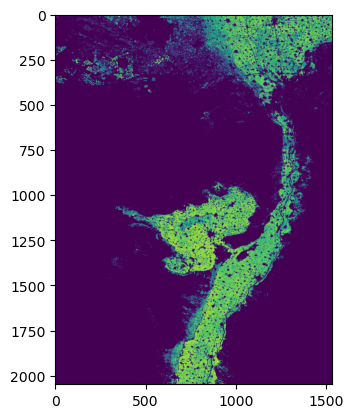

In [11]:
band = ds.GetRasterBand(1)
array = band.ReadAsArray().astype(float)
array[array == band.GetNoDataValue()] = np.nan
plt.imshow(array)

### Shapefile

Instead of specifying a `bounding_box`, it is also possible to pass a vector (e.g. a shapefile) to `gdal.Warp`. Doing so, we can download only the part of the GeoTIFF that overlaps with the shape. Additionaly, we can filter the different features inside the vector. Here we will load a shapefile containing 177 country borders and filter out Tanzania 🇹🇿 using its [ISO 3166 country code](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) `TZA`.

> ⚠️ You'll see that again we have to add a a string (`"/vsizip//vsicurl/"`) in front of the URL pointing to the shapefile, this is to tell `gdal` that we are not dealing with a normal local file, but with a ***zip***file somewhere on a server (see [here](https://gdal.org/user/virtual_file_systems.html#gdal-virtual-file-systems-compressed-network-hosted-etc-vsimem-vsizip-vsitar-vsicurl) for more info).

In [14]:
zip_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
file_path = "ne_110m_admin_0_countries.shp" # location of the shapefile inside the zipfile.
shape_url = f"/vsizip//vsicurl/{zip_url}/{file_path}"

Next we define new `gdal.WarpOptions`. Notice that here we also specify that we only want to use features from our shapefile for which the `SOV_A3` attribute is equal to the country code of our choice.

In [15]:
country_code = "TZA"

warp_options = gdal.WarpOptions(
    cutlineDSName=shape_url,
    cropToCutline=True,
    cutlineWhere=f'"SOV_A3"=\'{country_code}\'',
)

Finally, we can run `gdal.Warp` again and create a plot of the data we've downloaded as we've done before.

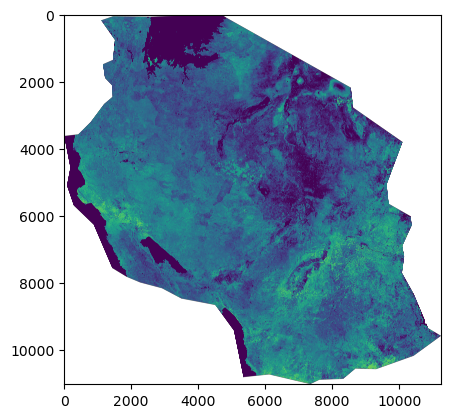

In [16]:
ds = gdal.Warp(output_filepath, f"/vsicurl/{tif_url}", options = warp_options)

band = ds.GetRasterBand(1)
array = band.ReadAsArray().astype(float)
array[array == band.GetNoDataValue()] = np.nan
plt.imshow(array)

## Creating a GEE ImageCollection

Using the `all_rasters` and mapset-`code` variables we've defined above we can also create an Google Earth Engine image-collection.

First we need to create some Google Storage URLS using the raster and mapset codes.

In [68]:
gs_urls = [f"gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/{mapset_code}/{raster_code[0]}.tif" for raster_code in all_rasters[:5]]
gs_urls

['gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2022-01-D1.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2022-01-D2.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2022-01-D3.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2022-02-D1.tif',
 'gs://fao-gismgr-wapor-3-data/DATA/WAPOR-3/MAPSET/L2-T-D/WAPOR-3.L2-T-D.2022-02-D2.tif']

> Alternatively, you can also find these Google Storage URLS by listing `gsutiUri` instead of `downloadUrl`, i.e. by running `collect_responses(mapset_url, info = ["code", "gsutilUri"])`

Then you can pass these urls to the following function. Note that you'll first have to authenticate and initialize you Earth Engine account using `ee.Authenticate()` and `ee.Initialize()`.

In [69]:
def create_collection(urls):
    img_list = ee.List([])
    regex_strings = {
        "D": r"\d{4}-\d{2}-D\d{1}",
        "M": r"\d{4}-\d{2}",
        "A": r"\d{4}",
    }
    for url_ in urls:
        regex_string = regex_strings[re.search(r"\/L\d-\w+-([ADM])\/", url_).group(1)]
        band_name = re.search(regex_string, url_)[0]
        img_list = img_list.add(ee.Image.loadGeoTIFF(url_).select(["B0"], [band_name]))
    return ee.ImageCollection(img_list)
